In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:53, 3735.41it/s]


### Часть 1. Анализ текстов

1. Посчитайте количество отзывов в разных городах на разные банки

In [138]:
import pandas as pd

In [139]:
resp_df = pd.DataFrame(responses)

In [140]:
resp_df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [8]:
resp_df.shape

(153499, 10)

In [9]:
resp_df.city.value_counts()

г. Москва                  55354
г. Санкт-Петербург         14342
г. Екатеринбург             2337
г. Новосибирск              2300
г. Нижний Новгород          1976
                           ...  
г. СПб и Москва                1
г. Бийск (Москва)              1
г. Симбирск (Ульяновск)        1
г. Плесецк                     1
г. с.Топольное                 1
Name: city, Length: 5823, dtype: int64

In [10]:
resp_df.bank_name.value_counts()

Сбербанк России               26327
Альфа-Банк                    10224
ВТБ 24                         8185
Русский Стандарт               7943
Хоум Кредит Банк               7549
                              ...  
Москва-Сити                       1
ИНГ Банк                          1
Камабанк                          1
Национальный Торговый Банк        1
Златкомбанк                       1
Name: bank_name, Length: 670, dtype: int64

2. Постройте гистограммы длин слов в символах и в словах

In [11]:
# "Постройте гистограммы длин слов в словах" - это круто.
# Вероятно, имелось в виду "Постройте гистограммы длин отзывов в символах и в словах" - тогда это делает смысл.

<AxesSubplot:>

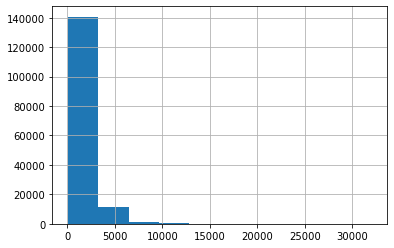

In [12]:
# гистограмма длин отзывов в символах
resp_df.text.apply(len).hist()

<AxesSubplot:>

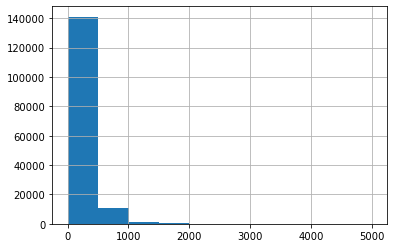

In [13]:
# гистограмма длин отзывов в словах
resp_df.text.apply(lambda x: len(x.split())).hist()

3. Найдите 10 самых частых:

In [14]:
from nltk.tokenize import word_tokenize
from string import punctuation
from collections import Counter

corpus = [token for response in tqdm(resp_df.text) for token in word_tokenize(response) if token not in punctuation]

100%|██████████| 153499/153499 [05:02<00:00, 507.27it/s] 


In [15]:
# топ 10 слов
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('в', 1169557),
 ('и', 980761),
 ('не', 816419),
 ('на', 638715),
 ('что', 603171),
 ('я', 443478),
 ('с', 428021),
 ('по', 338743),
 ('мне', 293980),
 ('банка', 235176)]

In [16]:
# сразу создадим словарь, в котором будет содержатсья вся информация о каждом встречаемом слове
# это существенно сэкономит время и оперативку

from nltk.corpus import stopwords
stops_rus = stopwords.words('russian')
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

corpus_with_params = {}

for word, count in tqdm(freq_dict.items()):
    corpus_with_params[word] = {'count': count,
                                'is_stop': word in stops_rus,
                                'normal_form': pymorphy2_analyzer.parse(word)[0].normal_form,
                                'tag': pymorphy2_analyzer.parse(word)[0].tag.POS}
    
corpus = ''

100%|██████████| 540842/540842 [02:52<00:00, 3140.25it/s]


In [17]:
word_params_df = pd.DataFrame(corpus_with_params).T

In [18]:
word_params_df.head()

,count,is_stop,normal_form,tag
Добрый,17397,False,добрый,ADJF
день,74627,False,день,NOUN
Я,130418,False,я,NPRO
не,816419,True,не,PRCL
являюсь,13763,False,являться,VERB


In [19]:
# топ 10 слов без стоп-слов

word_params_df[word_params_df.is_stop == False].sort_values(['count'], ascending = False)[:10]

,count,is_stop,normal_form,tag
банка,235176,False,банк,NOUN
``,220777,False,``,None
'',215526,False,'',None
банк,159569,False,банк,NOUN
это,158915,False,это,PRCL
В,152959,False,в,PREP
Я,130418,False,я,NPRO
деньги,121778,False,деньга,NOUN
...,113647,False,...,None
карту,101181,False,карта,NOUN


In [20]:
# топ 10 лемм

word_params_df.groupby('normal_form').agg({'count': 'sum'}).sort_values(['count'], ascending = False)[:10]

,count
normal_form,
в,1341688
я,1118795
и,1054485
не,851742
на,704396
что,644916
банк,624274
с,514990
быть,420834


In [21]:
# топ 10 существительных

word_params_df[word_params_df.tag == 'NOUN'].sort_values(['count'], ascending = False)[:10]

,count,is_stop,normal_form,tag
банка,235176,False,банк,NOUN
банк,159569,False,банк,NOUN
деньги,121778,False,деньга,NOUN
карту,101181,False,карта,NOUN
карты,99040,False,карта,NOUN
раз,74649,True,раз,NOUN
день,74627,False,день,NOUN
кредит,71824,False,кредит,NOUN
заявление,65006,False,заявление,NOUN
отделение,63424,False,отделение,NOUN


4. Постройте кривые Ципфа и Хипса

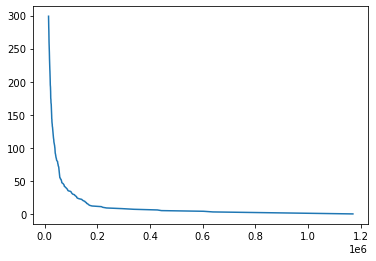

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

100%|██████████| 153499/153499 [05:27<00:00, 469.00it/s]


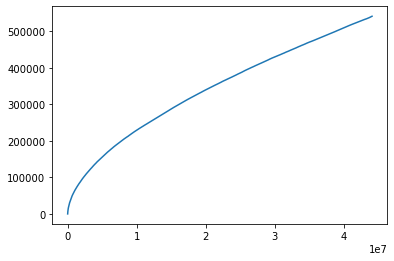

In [23]:
cnt = Counter()
n_words = []
total_tokens = 0
n_tokens = []
tokens = []
for index, row in tqdm(resp_df.iterrows(), total = len(resp_df)):
    tokens = word_tokenize(row['text'])
    total_tokens += len(tokens)
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(total_tokens)
    
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

Какое слово встречается чаще, "сотрудник" или "клиент"?

In [24]:
word_params_df.loc['сотрудник']['count']

24513

In [25]:
word_params_df.loc['клиент']['count']

15595

Сколько раз встречается слова "мошенничество" и "доверие"?

In [26]:
word_params_df.loc['мошенничество']['count']

972

In [27]:
word_params_df.loc['доверие']['count']

1024

В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(tokenizer=word_tokenize,
                         ngram_range=(1, 2),
                         min_df=0.01, max_df=0.3,
                         stop_words=list(punctuation) + stops_rus + ['«', '»'])
X = tf_idf.fit_transform(resp_df.text)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [31]:
tf_idf_df = pd.DataFrame(data=X.todense(), columns=tf_idf.get_feature_names())

In [32]:
tf_idf_df['rating_grade'] = resp_df['rating_grade']

In [33]:
grouped_tfidf = tf_idf_df.groupby(['rating_grade']).agg(sum)

In [34]:
# топ 10 токенов у низкорейтинговых отзывов
grouped_tfidf.T.sort_values([1.0], ascending=False)[:10]

rating_grade,1.0,2.0,3.0,4.0,5.0
...,1789.105154,492.473407,369.579578,116.547832,362.872510
карты,1351.864476,446.676911,272.175722,109.042608,314.399950
заявление,1300.301830,347.697926,172.312822,39.186384,125.064050
отделение,1236.937470,389.230428,214.290729,70.745786,269.643165
кредит,1200.391543,276.084700,208.481504,84.060250,391.861666
счет,1053.635068,275.026942,170.977787,67.976227,225.987160
дней,1047.997654,303.333709,159.417393,53.676249,167.235157
время,950.646017,299.890727,191.346465,86.725408,337.473005
ответ,907.241512,241.470892,126.569745,30.962414,84.463429
сказали,900.175228,246.560910,143.766265,35.586263,98.110525


In [35]:
# топ 10 токенов у низкорейтинговых отзывов
grouped_tfidf.T.sort_values([5.0], ascending=False)[:10]

rating_grade,1.0,2.0,3.0,4.0,5.0
очень,695.739848,217.507241,230.777491,157.945542,851.570292
спасибо,231.901013,84.876501,80.190738,73.311080,542.787430
быстро,163.790810,68.349606,92.081565,100.132300,510.029475
вклад,652.417080,254.679626,210.548189,131.258733,410.099837
кредит,1200.391543,276.084700,208.481504,84.060250,391.861666
приятно,44.496540,17.399647,29.452241,53.050946,364.503536
...,1789.105154,492.473407,369.579578,116.547832,362.872510
минут,754.102989,258.693200,174.563587,86.334914,337.927160
время,950.646017,299.890727,191.346465,86.725408,337.473005
карты,1351.864476,446.676911,272.175722,109.042608,314.399950


### Часть 2. Тематическое моделирование

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [141]:
from nltk.corpus import stopwords
import re
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

from tqdm.notebook import tqdm
tqdm.pandas()

mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text):
    try:
        return " ".join(morph.parse(word)[0].normal_form for word in text.split())  
    except:
        return " "


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [ ]:
#resp_df = resp_df[:5000]

In [142]:
resp_df.text = resp_df.text.progress_apply(preprocess)

In [143]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [144]:
texts = [text.split() for text in resp_df[:5000].text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [145]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [146]:
from gensim.models import lsimodel

In [147]:
%%time

n_themes = 5

lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=n_themes)

lsi.show_topics(n_themes)

Wall time: 2.02 s


[(0,
  '0.195*"карта" + 0.139*"кредит" + 0.118*"деньга" + 0.112*"вклад" + 0.105*"счёт" + 0.103*"заявление" + 0.102*"отделение" + 0.101*"сумма" + 0.099*"сбербанк" + 0.098*"сотрудник"'),
 (1,
  '-0.254*"звонок" + 0.248*"вклад" + -0.228*"номер" + 0.205*"карта" + -0.192*"ваш" + -0.173*"кредит" + -0.153*"телефон" + -0.142*"данные" + -0.135*"персональный" + -0.135*"поступать"'),
 (2,
  '-0.665*"вклад" + -0.208*"ставка" + 0.196*"карта" + -0.164*"договор" + 0.157*"банкомат" + -0.150*"условие" + 0.148*"сбербанк" + -0.133*"пополнение" + -0.117*"процент" + -0.105*"вкладчик"'),
 (3,
  '-0.369*"страховка" + -0.306*"кредит" + -0.294*"страхование" + 0.227*"вклад" + 0.183*"номер" + -0.150*"договор" + -0.149*"страховой" + 0.135*"карта" + -0.129*"погашение" + 0.125*"звонок"'),
 (4,
  '-0.209*"средство" + -0.180*"денежный" + -0.175*"платёж" + 0.171*"заявка" + -0.166*"сумма" + -0.147*"счёт" + -0.143*"договор" + -0.133*"руб" + 0.125*"отделение" + -0.123*"погашение"')]

В данном случае тема №3 явно связана с процентами по договору вклада

In [148]:
%%time
n_themes = 10

lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=n_themes)

lsi.show_topics(n_themes)

Wall time: 2.04 s


[(0,
  '0.195*"карта" + 0.139*"кредит" + 0.118*"деньга" + 0.112*"вклад" + 0.105*"счёт" + 0.103*"заявление" + 0.102*"отделение" + 0.101*"сумма" + 0.099*"сбербанк" + 0.098*"сотрудник"'),
 (1,
  '0.254*"звонок" + -0.248*"вклад" + 0.228*"номер" + -0.205*"карта" + 0.192*"ваш" + 0.173*"кредит" + 0.153*"телефон" + 0.142*"данные" + 0.136*"персональный" + 0.135*"поступать"'),
 (2,
  '-0.665*"вклад" + -0.206*"ставка" + 0.196*"карта" + -0.163*"договор" + 0.157*"банкомат" + -0.151*"условие" + 0.147*"сбербанк" + -0.135*"пополнение" + -0.119*"процент" + -0.106*"вкладчик"'),
 (3,
  '-0.369*"страховка" + -0.306*"кредит" + -0.294*"страхование" + 0.227*"вклад" + 0.182*"номер" + -0.150*"договор" + -0.148*"страховой" + 0.136*"карта" + -0.129*"погашение" + 0.126*"звонок"'),
 (4,
  '-0.208*"средство" + -0.179*"денежный" + -0.172*"платёж" + 0.172*"заявка" + -0.165*"сумма" + -0.150*"счёт" + -0.149*"договор" + -0.132*"руб" + 0.126*"отделение" + -0.124*"погашение"'),
 (5,
  '0.274*"страхование" + -0.251*"платёж

Тема №5 связана со страховым возмещением по вкладам

2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

В теме №5 упоминание Сбербанка объяснимо: сама тема явно связано с выплатой страхового возмещения в ликвидируемых банка. Такие выплаты производятся через банки-агенты, основным из которых является как раз Сбер.

### Часть 3. Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

In [149]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [150]:
data = resp_df[(resp_df['rating_grade'] == 1) | (resp_df['rating_grade'] == 5)]

In [151]:
#data = data[:1000]

In [152]:
data.text = data.text.progress_apply(preprocess)

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [153]:
from sklearn.model_selection import train_test_split

In [154]:
X = data.text
y = data.rating_grade

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.

In [167]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1, 1))),
    ('clf', RandomForestClassifier(n_estimators = 1000)),
])

clf.fit(X_train, y_train)

print(accuracy_score(y_test, clf.predict(X_test)))
print(f1_score(y_test, clf.predict(X_test)))

0.9081588835212023
0.9430596692069619


In [168]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range = (2, 2))),
    ('clf', RandomForestClassifier(n_estimators = 1000)),
])

clf.fit(X_train, y_train)

print(accuracy_score(y_test, clf.predict(X_test)))
print(f1_score(y_test, clf.predict(X_test)))

0.9140633387010199
0.9462047646248446


In [169]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range = (3, 3))),
    ('clf', RandomForestClassifier(n_estimators = 1000)),
])

clf.fit(X_train, y_train)

print(accuracy_score(y_test, clf.predict(X_test)))
print(f1_score(y_test, clf.predict(X_test)))

0.8555555555555555
0.9125134107090608


In [166]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
    ('clf', RandomForestClassifier(n_estimators = 1000)),
])

clf.fit(X_train, y_train)

print(accuracy_score(y_test, clf.predict(X_test)))
print(f1_score(y_test, clf.predict(X_test)))

0.9063338701019861
0.9419475032436209


3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [165]:
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier(n_estimators = 1000))
])

clf.fit(X_train, y_train)

print(accuracy_score(y_test, clf.predict(X_test)))
print(f1_score(y_test, clf.predict(X_test)))

0.7309178743961353
0.8372983674661646


In [164]:
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('lda', LatentDirichletAllocation()),
    ('clf', RandomForestClassifier(n_estimators = 1000))
])

clf.fit(X_train, y_train)

print(accuracy_score(y_test, clf.predict(X_test)))
print(f1_score(y_test, clf.predict(X_test)))

0.9353193773483629
0.9580679959633921
